# Classifier Hyper-heuristic

Install dependencies

In [ ]:
!pip3 install pickle5 &> /dev/null
!pip install dtreeviz &> /dev/null
!pip install keras-tuner &> /dev/null

Import packages

In [ ]:
from google.colab            import files
from google.colab            import drive

import pickle5 as pickle
import pandas as pd
import os

import matplotlib.pyplot     as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing   import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

#from sklearn import metrics
from sklearn.metrics         import confusion_matrix, roc_curve, roc_auc_score, auc, ConfusionMatrixDisplay, mean_squared_error
from sklearn.metrics._plot.confusion_matrix import plot_confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler

from dtreeviz.trees import dtreeviz
from sklearn.tree import plot_tree
import matplotlib.font_manager
from matplotlib.pyplot import figure

drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Preprocessing

Load database

In [ ]:
path     = '/content/gdrive/Shareddrives/CS4012/Jupyter notebooks/data/'
filename = 'database_k15.pkl'

with open(path + filename, "rb") as fh:
  df = pickle.load(fh)

In [ ]:
df.head()

,EDGE_DENSITY,AVG_DEGREE,BURNING_NODES,BURNING_EDGES,NODES_IN_DANGER,CLASS
0,0.007626,0.007628,0.001,0.000005,0.005,LDEG
1,0.007616,0.007627,0.006,0.000034,0.034,LDEG
2,0.007548,0.007596,0.040,0.000255,0.234,LDEG
3,0.007053,0.007247,0.266,0.001734,0.809,LDEG
4,0.004430,0.005386,0.874,0.003752,0.924,LDEG


Visualize class distribution

In [ ]:
unique, counts = np.unique(df.CLASS, return_counts=True)
dict(zip(unique, counts))

{'GDEG': 48, 'LDEG': 1516}

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


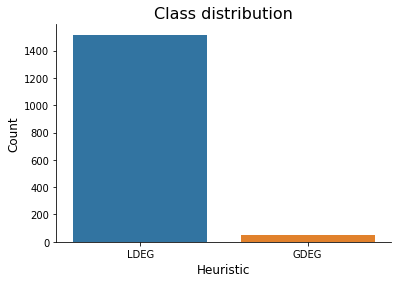

In [ ]:
plt.title('Class distribution', size=16)
sns.countplot(df['CLASS'])
plt.ylabel('Count', size=12)
plt.xlabel('Heuristic', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

Preprocessing: Label encoding

In [ ]:
le = LabelEncoder()
le.fit(df['CLASS'])
df['CLASS'] = le.transform(df['CLASS'])

In [ ]:
df

,EDGE_DENSITY,AVG_DEGREE,BURNING_NODES,BURNING_EDGES,NODES_IN_DANGER,CLASS
0,0.007626,0.007628,0.001,0.000005,0.005,1
1,0.007616,0.007627,0.006,0.000034,0.034,1
2,0.007548,0.007596,0.040,0.000255,0.234,1
3,0.007053,0.007247,0.266,0.001734,0.809,1
4,0.004430,0.005386,0.874,0.003752,0.924,1
...,...,...,...,...,...,...
1559,0.132245,0.153061,0.920,0.120000,0.980,1
1560,0.253061,0.252395,0.020,0.005714,0.280,1
1561,0.241633,0.251312,0.300,0.065714,0.500,1
1562,0.204898,0.238095,0.520,0.090612,0.920,1


In [ ]:
df.describe()

,EDGE_DENSITY,AVG_DEGREE,BURNING_NODES,BURNING_EDGES,NODES_IN_DANGER,CLASS
count,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000
mean,0.039227,0.042763,0.443038,0.012395,0.532808,0.969309
std,0.054005,0.056735,0.360842,0.023505,0.347402,0.172533
min,0.003079,0.001001,0.001000,0.000001,0.001000,0.000000
25%,0.007418,0.009775,0.082750,0.001077,0.180000,1.000000
50%,0.012619,0.014750,0.380000,0.003465,0.555500,1.000000
75%,0.053636,0.060207,0.817000,0.009047,0.890000,1.000000
max,0.291429,0.303365,0.999000,0.175102,0.996000,1.000000


Extract data for training

In [ ]:
X = df.loc[:, df.columns != 'CLASS']
y = df['CLASS']

In [ ]:
feature_names = X.columns

Feature normalization

In [ ]:
ss = StandardScaler()
X = pd.DataFrame(ss.fit_transform(X) ,columns = feature_names)

Plot correlation between features

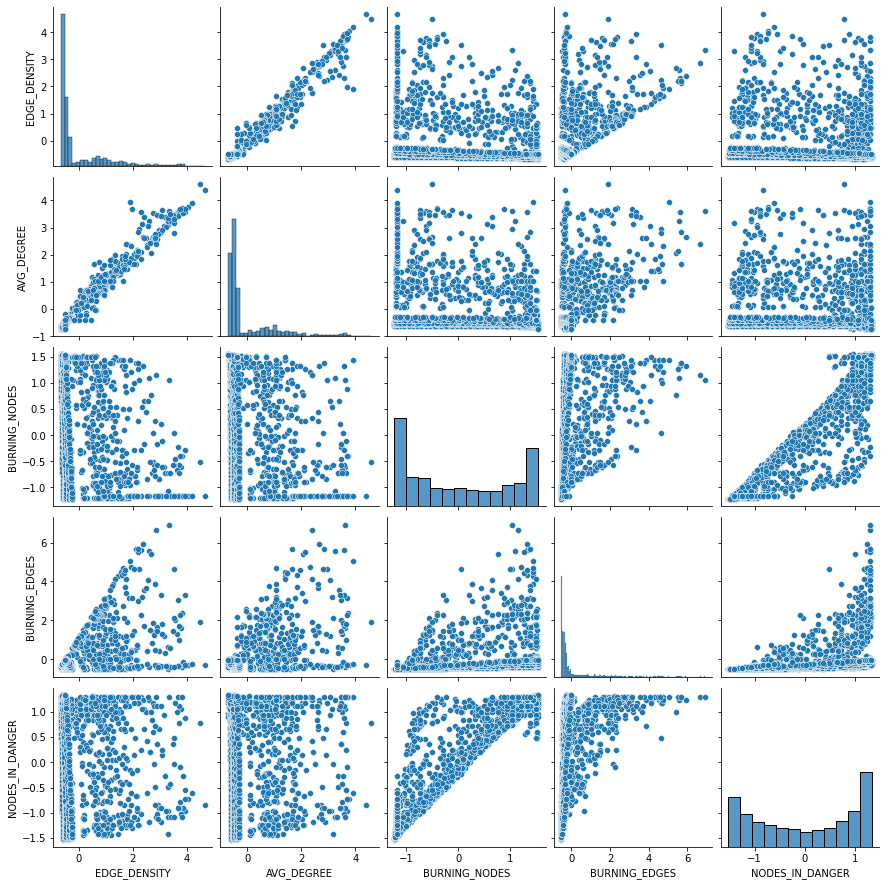

In [ ]:
sns.pairplot(X)

In [ ]:
matrix = X.corr().round(2)

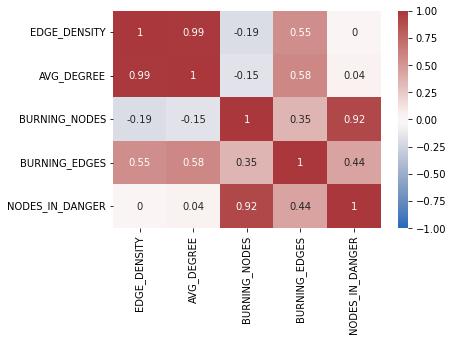

In [ ]:
sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag')
plt.show()

The features:  

- 'Edge density' and 'Average degree' are highly correlated.
- 'Node is danger' and 'Burning nodes' are highly correlated.

This results suggest that out of the 5 features, we could keep only 3 of them.


In [ ]:
# Remove: AVG_DEGREE and BURNING_NODES
# X = X[['EDGE_DENSITY','BURNING_EDGES', 'NODES_IN_DANGER']]

Principal component analysis

In [ ]:
#UPDATE: This is potentially wrong because I need to divide into train and test first. The PCA shall be done on train and test data needs to be projected to the PCAs
#        See: https://stats.stackexchange.com/questions/142216/zero-centering-the-testing-set-after-pca-on-the-training-set
#             https://stats.stackexchange.com/questions/55718/pca-and-the-train-test-split

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [ ]:
finalDf = pd.concat([principalDf, df[['CLASS']]], axis = 1)

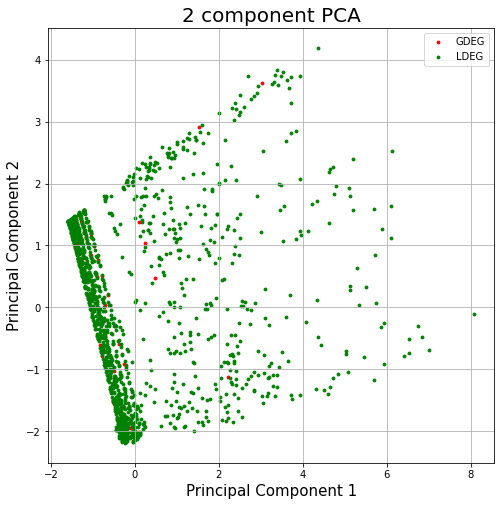

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['CLASS'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 8)
ax.legend(['GDEG','LDEG'])
ax.grid()

Variance explained by each component

In [ ]:
print(pca.explained_variance_ratio_)

[0.50044518 0.41448522]


In [ ]:
pca.components_

array([[ 0.54137249,  0.55523352,  0.17483407,  0.53854184,  0.27935157],
       [ 0.33085904,  0.30434534, -0.65220538, -0.12471958, -0.59747751]])

## Model implementation

In [ ]:
# OBS: This is perhaps wrong because X was normalized before splitting into train and test (leakage??)
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

### Decision tree classifier

In [ ]:
clf_dt = DecisionTreeClassifier()

Training phase

In [ ]:
path = clf_dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1]

In [ ]:
# Make a dictionary of hyperparameter values to search
search_space = {
    "max_depth" : [1,2,3,4,5,6,7,8,9,10],
    "ccp_alpha" : ccp_alphas
}

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=3, random_state=42)

GS = GridSearchCV(estimator=clf_dt,
                  param_grid=search_space,
                  scoring=["accuracy"],
                  refit="accuracy",
                  cv=cv)

In [ ]:
GS.fit(X_train, y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=4, random_state=42),
             estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': array([0.        , 0.00056834, 0.00063939, 0.00071043, 0.00082668,
       0.00082988, 0.0008444 , 0.00084753, 0.00084836, 0.00086654,
       0.00087437, 0.00091147, 0.00092301, 0.00095081, 0.00113669,
       0.00164959, 0.00166186]),
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             refit='accuracy', scoring=['accuracy'])

In [ ]:
best_dt = GS.best_estimator_
print(GS.best_params_)

{'ccp_alpha': 0.0, 'max_depth': 1}


In [ ]:
# Best score during training
print(GS.best_score_)

0.9693093961133941


Visualize the decision tree

In [ ]:
#plt.figure(figsize=(15,7.5))
#plot_tree(best_dt, filled=True, rounded=True, class_names=['GDEG','LDEG'], feature_names=X.columns)

In [ ]:
from dtreeviz.trees import dtreeviz
import matplotlib.font_manager
from matplotlib.pyplot import figure

feature_names = X_test.columns
viz = dtreeviz(best_dt, X_test, y_test,
                target_name="heuristic",
                feature_names=feature_names,
                class_names=['GDEG','LDEG'])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


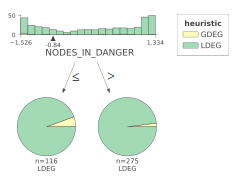

In [ ]:
viz

Performance evaluation

In [ ]:
predictions = best_dt.predict(X_test)

Accuracy of DT classifier on training set: 0.97
Accuracy of DT classifier on test set: 0.97
F1 score of DT classifier on test set: 0.98
----------------------------------
              precision    recall  f1-score   support

        GDEG       0.00      0.00      0.00        12
        LDEG       0.97      1.00      0.98       379

    accuracy                           0.97       391
   macro avg       0.48      0.50      0.49       391
weighted avg       0.94      0.97      0.95       391

----------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


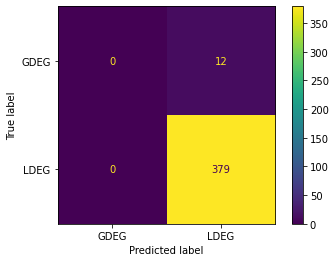

In [ ]:
print('Accuracy of DT classifier on training set: {:.2f}'
     .format(best_dt.score(X_train, y_train)))
print('Accuracy of DT classifier on test set: {:.2f}'
     .format(best_dt.score(X_test, y_test)))
print('F1 score of DT classifier on test set: {:.2f}'
     .format(f1_score(y_test, predictions)))
print("----------------------------------")
print(classification_report(y_test, predictions, target_names=['GDEG','LDEG']))
print("----------------------------------")
cm   = confusion_matrix(y_test, predictions, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['GDEG','LDEG'])
disp.plot()

###  Multi layer perceptron

In [ ]:
estimator_MLP = MLPClassifier(batch_size='auto', warm_start=True, max_iter=400)
parameters_MLP = {
    'hidden_layer_sizes': [(10,),(20,),(50,),(100,)],
    'activation': ['tanh', 'relu'],
    'alpha': [0.0001, 0.05],
    'solver': ['sgd', 'adam'],
    'learning_rate' : ['constant','adaptive']
                   }

cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=3, random_state=42)

# with GridSearch
grid_search_MLP = GridSearchCV(
    estimator=estimator_MLP,
    param_grid=parameters_MLP,
    scoring = 'accuracy',
    cv = cv)

In [ ]:
grid_search_MLP.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=4, random_state=42),
             estimator=MLPClassifier(max_iter=400, warm_start=True),
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(10,), (20,), (50,), (100,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']},
             scoring='accuracy')

In [ ]:
best_mlp = grid_search_MLP.best_estimator_
print(best_mlp)

MLPClassifier(activation='tanh', hidden_layer_sizes=(10,), max_iter=400,
              solver='sgd', warm_start=True)


In [ ]:
y_pred_MLP1 =best_mlp.predict(X_test)

Accuracy of DT classifier on training set: 0.97
Accuracy of DT classifier on test set: 0.97
----------------------------------
              precision    recall  f1-score   support

        GDEG       0.00      0.00      0.00        12
        LDEG       0.97      1.00      0.98       379

    accuracy                           0.97       391
   macro avg       0.48      0.50      0.49       391
weighted avg       0.94      0.97      0.95       391

----------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


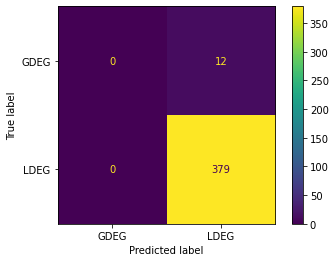

In [ ]:
print('Accuracy of DT classifier on training set: {:.2f}'
     .format(best_mlp.score(X_train, y_train)))
print('Accuracy of DT classifier on test set: {:.2f}'
     .format(best_mlp.score(X_test, y_test)))
print("----------------------------------")
print(classification_report(y_test, y_pred_MLP1, target_names=['GDEG','LDEG']))
print("----------------------------------")
cm   = confusion_matrix(y_test, y_pred_MLP1, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['GDEG','LDEG'])
disp.plot()

### Linear discriminant analysis

In [ ]:
from numpy import arange
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# define model
lda_model = LinearDiscriminantAnalysis(solver='lsqr')
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid['shrinkage'] = arange(0, 1, 0.01)
# define search
search = GridSearchCV(lda_model, grid, scoring='accuracy', cv=cv)
# perform the search
results = search.fit(X, y)
# summarize
print('Mean Accuracy: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

Mean Accuracy: 0.969
Config: {'shrinkage': 0.0}


In [ ]:
best_lda = search.best_estimator_
print(search.best_params_)

{'shrinkage': 0.0}


In [ ]:
predictions = best_lda.predict(X_test)

Accuracy of DT classifier on training set: 0.97
Accuracy of DT classifier on test set: 0.97
----------------------------------
              precision    recall  f1-score   support

        GDEG       0.00      0.00      0.00        12
        LDEG       0.97      1.00      0.98       379

    accuracy                           0.97       391
   macro avg       0.48      0.50      0.49       391
weighted avg       0.94      0.97      0.95       391

----------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


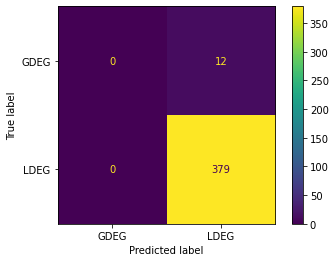

In [ ]:
print('Accuracy of DT classifier on training set: {:.2f}'
     .format(best_lda.score(X_train, y_train)))
print('Accuracy of DT classifier on test set: {:.2f}'
     .format(best_lda.score(X_test, y_test)))
print("----------------------------------")
print(classification_report(y_test, predictions, target_names=['GDEG','LDEG']))
print("----------------------------------")
cm   = confusion_matrix(y_test, predictions, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['GDEG','LDEG'])
disp.plot()

## Save model to file

In this section we select one of the best models found to export it to a binary file that can be opened in the FFP framework to be used as the hyper-heuristic. Before saving the best model, we retrain with the complete database as we still have a portion of the dataset saved for testing purposes (comparing the hyper-heuristic to the standalone heuristics). This way we take advantage of our limited dataset.

In [ ]:
# Select the best model
best = best_dt  # Select one between: best_dt, best_mlp, best_lda

In [ ]:
best.fit(X,y)

DecisionTreeClassifier(max_depth=1)

In [ ]:
model_filename = 'dt_classifier_hh.pkl'

with open(model_filename, 'wb') as file:
  pickle.dump(best, file)

### Test model with single sample

This section shows how the model can be used in the FFP framework side. The features for the problem at hand need to be stored in a dataframe and passed to the model predict method. Finally, the model returns the predicted heuristic to use to minimze the performance index.



In [ ]:
# Sample data

sample_df = pd.DataFrame([[0.007626, 0.007628,	0.001,	0.000005,	0.005]], columns=["EDGE_DENSITY", "AVG_DEGREE", "BURNING_NODES", "BURNING_EDGES", "NODES_IN_DANGER"])

In [ ]:
sample_df

,EDGE_DENSITY,AVG_DEGREE,BURNING_NODES,BURNING_EDGES,NODES_IN_DANGER
0,0.007626,0.007628,0.001,0.000005,0.005


In [ ]:
heuristic_pred = best.predict(sample_df)

In [ ]:
heuristic_pred[0]

1